<class 'pandas.core.frame.DataFrame'>
RangeIndex: 524950 entries, 0 to 524949
Data columns (total 17 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   WEEK_END_DATE  524950 non-null  object 
 1   STORE_NUM      524950 non-null  int64  
 2   UPC            524950 non-null  int64  
 3   UNITS          524950 non-null  int64  
 4   VISITS         524950 non-null  int64  
 5   HHS            524950 non-null  int64  
 6   SPEND          524950 non-null  float64
 7   PRICE          524949 non-null  float64
 8   BASE_PRICE     524950 non-null  float64
 9   FEATURE        524950 non-null  int64  
 10  DISPLAY        524950 non-null  int64  
 11  TPR_ONLY       524950 non-null  int64  
 12  DESCRIPTION    524950 non-null  object 
 13  MANUFACTURER   524950 non-null  object 
 14  CATEGORY       524950 non-null  object 
 15  SUB_CATEGORY   524950 non-null  object 
 16  PRODUCT_SIZE   524950 non-null  object 
dtypes: float64(3), int64(8), obje

C:\Users\Balli\AppData\Local\Temp\ipykernel_3264\657790854.py:77: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  PT_dataset['DATE']=pd.to_datetime(PT_dataset['WEEK_END_DATE'])


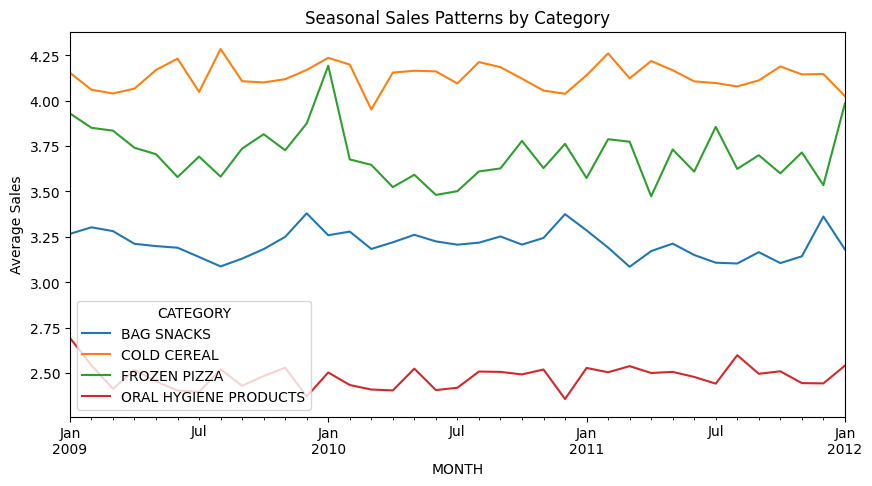

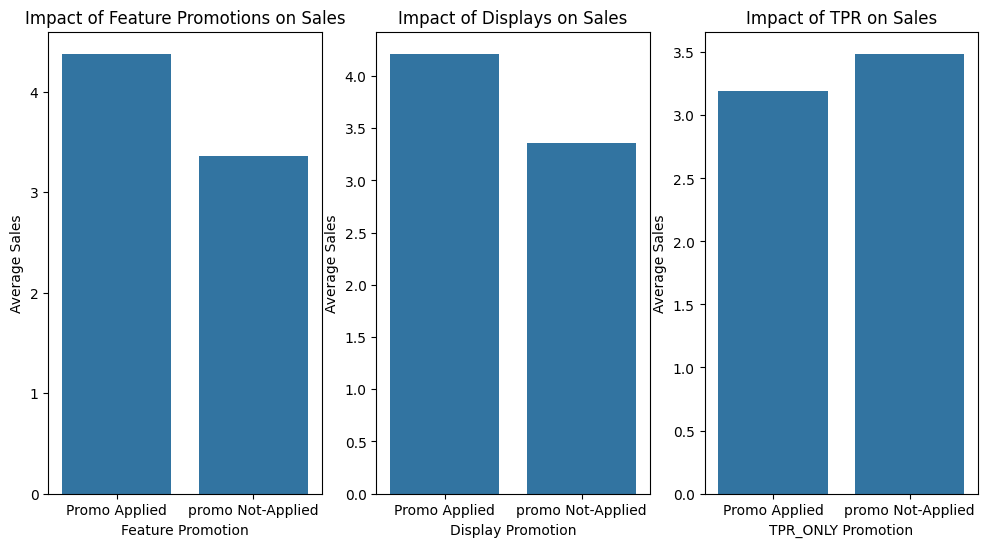

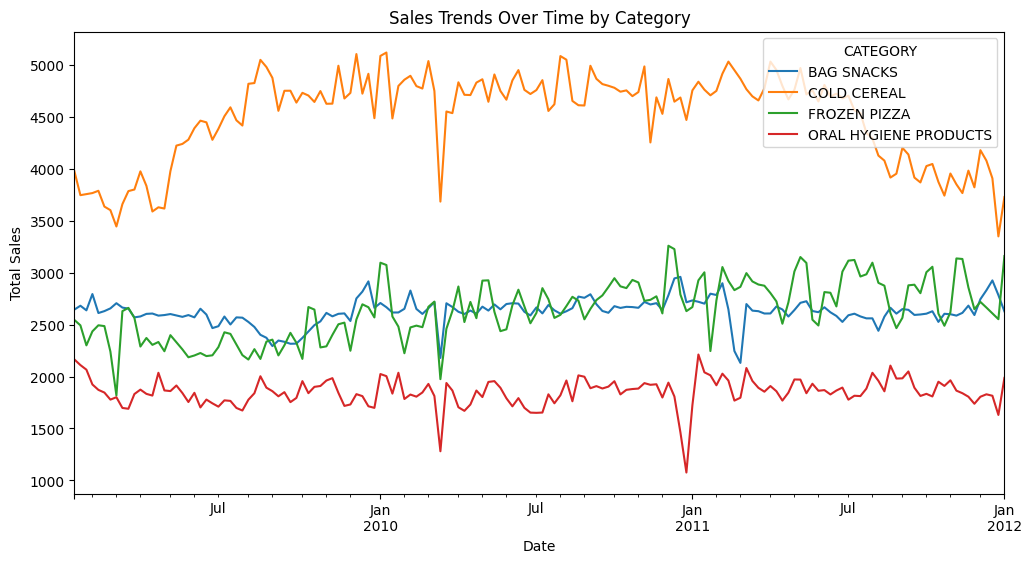

In [3]:
%matplotlib inline
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn.linear_model import LinearRegression
from statsmodels.formula.api import ols



# First we have to load our dataset into python for further processing and analytics


path = os.path.abspath('C:/Users/Balli/Pictures/FourDataFile')

transaction_data=pd.read_csv(path +'/fw-transaction-data.csv')

product_data = pd.read_csv(path + '/fw-product-lookup.csv')

store_data = pd.read_csv(path + '/fw-store-lookup.csv')

# Note PT means Product and transaction dataset

PT_dataset = pd.merge(transaction_data,product_data, on='UPC', how='left')
# print(PT_dataset.head())


#PT_dataset.describe()
#PT_dataset.info()
nullrows=PT_dataset[PT_dataset['PRICE'].isnull()]
nullrows1=PT_dataset[PT_dataset['BASE_PRICE'].isnull()]
#print(nullrows1)

#Replacing the null row in the Price column with the mean value of the distribution 
mean_price = PT_dataset['PRICE'].mean()
mode_price = PT_dataset['PRICE'].mode()
PT_dataset.loc[(PT_dataset['PRICE'].isna()),'PRICE']=mean_price
PT_dataset.loc[(PT_dataset['PRICE']==0),'PRICE']=mode_price

# Replacing the null row in the base price column with the mean value of the distribution
mean_price1 = PT_dataset['BASE_PRICE'].mean()
PT_dataset.loc[(PT_dataset['BASE_PRICE'].isna()),'BASE_PRICE']=mean_price1
PT_dataset.info()

#ASSESSMENT


#QUESTION 1
# To get the  production that is most sensitve to price. we are going to compute price change  in relation to sales
# and we are going to make use of linear regression analysis o predict sales given every one dollar change in price



# Add a column for log-transformed sales and price
PT_dataset['log_sales'] = np.log(PT_dataset['SPEND'] + 1) # + 1 to reduce the skewness of our data by round 0s to 1 
PT_dataset['log_price'] = np.log(PT_dataset['PRICE'] + 1)# + 1 to reduce the skewness of our data by round 0s to 1 

# Fit a linear regression model for each product
price_sensitivity = {}
for product in PT_dataset['UPC'].unique():
    product_data = PT_dataset[PT_dataset['UPC'] == product]
    model = ols('log_sales ~ log_price', data=product_data).fit()
    price_sensitivity[product] = round(model.params['log_price'],2)

# Sort products by price sensitivity
price_sensitivity = sorted(price_sensitivity.items(), key=lambda x: x[1], reverse=True)
price_sensitivity_df = pd.DataFrame(price_sensitivity)
print(f'Products most price sensitive:\n {price_sensitivity_df}')


#QUESTION 2 SOLUTION

# Aggregate sales by month and category

# Converting Week end date to a date format
PT_dataset['DATE']=pd.to_datetime(PT_dataset['WEEK_END_DATE'])

# Extracting month from the date to relay seasonal trend
PT_dataset['MONTH'] = PT_dataset['DATE'].dt.to_period('M')
seasonal_sales = PT_dataset.groupby(['MONTH', 'CATEGORY'])['log_sales'].mean().unstack()

# Plot seasonal sales patterns
seasonal_sales.plot(figsize=(10, 5))
plt.title('Seasonal Sales Patterns by Category')
plt.xlabel('MONTH')
plt.ylabel('Average Sales')
plt.show()

#QUESTION 3 SOLUTION

def int_to_string(value):
    if value == 1:
        return 'Promo Applied'
    else:
        return 'promo Not-Applied'


PT_dataset['FEATURE']=PT_dataset['FEATURE'].apply(int_to_string)

PT_dataset['DISPLAY']=PT_dataset['DISPLAY'].apply(int_to_string)

PT_dataset['TPR_ONLY']=PT_dataset['TPR_ONLY'].apply(int_to_string)


# Aggregate sales by promotion(display, feature and tempral price reduction TPR)
feature_promo= PT_dataset.groupby('FEATURE')['log_sales'].mean().reset_index()
display_promo = PT_dataset.groupby('DISPLAY')['log_sales'].mean().reset_index()
tpr_only_promo= PT_dataset.groupby('TPR_ONLY')['log_sales'].mean().reset_index()


# Plot the impacts
fig, ax = plt.subplots(1, 3, figsize=(12, 6))
sns.barplot(x=feature_promo['FEATURE'], y=feature_promo['log_sales'], ax=ax[0])
ax[0].set_title('Impact of Feature Promotions on Sales')
ax[0].set_xlabel('Feature Promotion')
ax[0].set_ylabel('Average Sales')

sns.barplot(x=display_promo['DISPLAY'], y=display_promo['log_sales'], ax=ax[1])
ax[1].set_title('Impact of Displays on Sales')
ax[1].set_xlabel('Display Promotion')
ax[1].set_ylabel('Average Sales')

sns.barplot(x=tpr_only_promo['TPR_ONLY'], y=tpr_only_promo['log_sales'], ax=ax[2])
ax[2].set_title('Impact of TPR on Sales')
ax[2].set_xlabel('TPR_ONLY Promotion')
ax[2].set_ylabel('Average Sales')
plt.show()


#QUESTION 4

# TO find trend i sales of a product category we will aggregate sales by date and product category
trend_data = PT_dataset.groupby(['DATE', 'CATEGORY'])['log_sales'].sum().unstack()

# Plot sales trends over time
trend_data.plot(figsize=(12, 6))
plt.title('Sales Trends Over Time by Category')
plt.xlabel('Date')
plt.ylabel('Total Sales')
plt.show()


